# 1) Setup colab runtime environment

# 1.1. Download Dataset

In [1]:
!git clone https://github.com/balarcode/deep-learning.git

Cloning into 'deep-learning'...
remote: Enumerating objects: 1223, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 1223 (delta 135), reused 73 (delta 22), pack-reused 953 (from 1)
Receiving objects: 100% (1223/1223), 64.96 MiB | 4.85 MiB/s, done.
Resolving deltas: 100% (201/201), done.
Updating files: 100% (797/797), done.


# 1.2. Common Imports

In [2]:
import sys
sys.path.append('/content/deep-learning/telecommunications/radio_signal_classification/data')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch # PyTorch machine learning framework
from torch import nn # PyTorch package to build and manage neural network architectures
from torch import optim # PyTorch package containing optimization algorithms
from torch.utils.data import Dataset, DataLoader # PyTorch data loading utility

from torchvision import transforms as T # PyTorch package containing image transformations

import timm # PyTorch image model library

from tqdm.notebook import tqdm

# 2) Setup Configuration

In [4]:
# Input dataset (training and validation)
TRAIN_CSV = '/content/deep-learning/telecommunications/radio_signal_classification/data/training.csv'
VALID_CSV = '/content/deep-learning/telecommunications/radio_signal_classification/data/validation.csv'

# Neural network settings
BATCH_SIZE = 128
DEVICE = 'cuda' # GPU will be used for execution; Use 'cpu' if GPU is unavailable
MODEL_NAME = 'efficientnet_b0'
LR = 0.001 # Learning rate
EPOCHS = 15 # Number of epochs

# Other configuration
height = 64
width = 128

In [5]:
df_train = pd.read_csv(TRAIN_CSV)
df_valid = pd.read_csv(VALID_CSV)

df_train.head() # Contains 8192 pixel values for each spectrogram;
                # Each row is a spectrogram

,0,1,2,3,4,5,6,7,8,9,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,labels
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667,Squiggle
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490,Squiggle
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510,Squiggle
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373,Squiggle
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412,Squiggle


In [6]:
print(f"Number of labeled examples in training dataset: {len(df_train)}")
print(f"Number of labeled examples in validation dataset: {len(df_valid)}")
print(f"Labels are: {df_train['labels'].unique()}")

Number of labeled examples in training dataset: 1199
Number of labeled examples in validation dataset: 800
Labels are: ['Squiggle' 'Narrowband_2' 'Noise' 'Narrowband_1']


In [7]:
# Function to plot the spectrogram from training set
def display_spectrogram(idx):
  row = df_train.iloc[idx]
  image_pixels = np.array(row[0:8191], dtype=np.float64)
  label = row.labels
  # Resize the spectrogram image; height x width = 8192
  image = np.resize(image_pixels, (height, width))
  plt.imshow(image)
  plt.title(label)

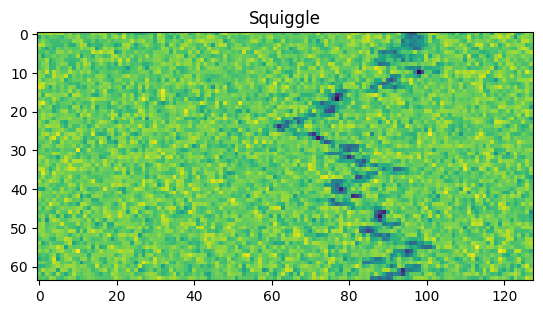

In [8]:
# Plot the spectrogram
idx = 2 # Spectrogram index
display_spectrogram(idx)

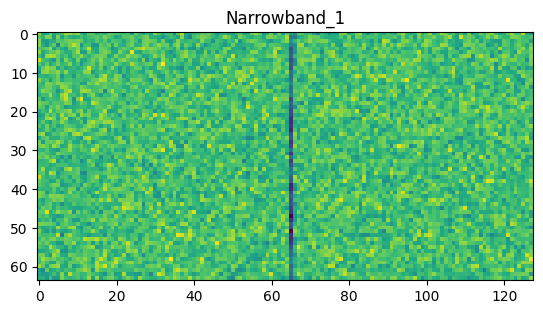

In [9]:
# Plot the spectrogram
idx = 1102 # Spectrogram index
display_spectrogram(idx)

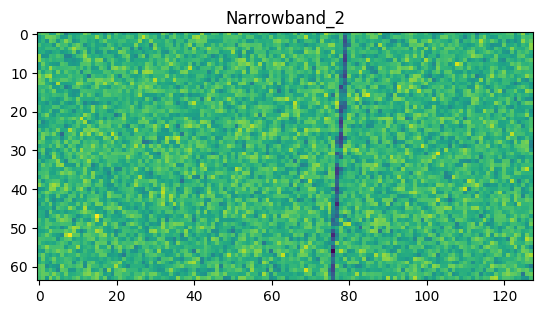

In [10]:
# Plot the spectrogram
idx = 401 # Spectrogram index
display_spectrogram(idx)

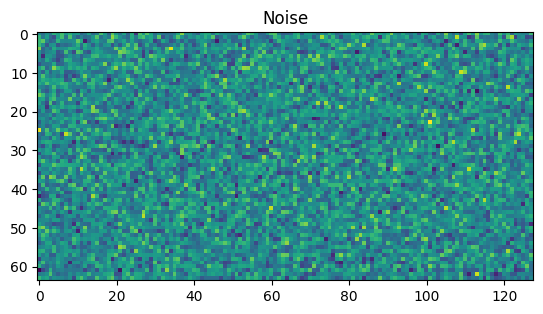

In [11]:
# Plot the spectrogram
idx = 808 # Spectrogram index
display_spectrogram(idx)

# 3) Augmentations

In [12]:
# For radio signal classification using spectrogram images, spectrogram
# augmentations known as time mask and frequency mask are applied.
# Time mask is applied in the vertical direction to form vertical stripes.
# Frequency mask is applied in the horizontal direction to form horizontal
# stripes. Together, the time and frequency masks would form a grid pattern
# on top of the spectrogram image.
class TimeMask(object):
    def __init__(self, T=40, num_masks=1, replace_with_zero=False):
        self.T = T
        self.num_masks = num_masks
        self.replace_with_zero = replace_with_zero

    def __call__(self, spec):
        cloned = spec.clone()
        len_spectro = cloned.shape[2]
        for i in range(0, self.num_masks):
            t = random.randrange(0, self.T)
            t_zero = random.randrange(0, len_spectro - t)

            if (t_zero == t_zero + t):
                return cloned

            mask_end = random.randrange(t_zero, t_zero + t)
            if(self.replace_with_zero):
                cloned[0][:, t_zero:mask_end] = 0
            else:
                cloned[0][:, t_zero:mask_end] = cloned.mean()
        return cloned

class FreqMask(object):
    def __init__(self, F=10, num_masks=1, replace_with_zero=False):
        self.F = F
        self.num_masks = num_masks
        self.replace_with_zero = replace_with_zero

    def __call__(self, spec):
        cloned = spec.clone()
        num_mel_channels = cloned.shape[1]
        for i in range(0, self.num_masks):
            f = random.randrange(0,self.F)
            f_zero = random.randrange(0, num_mel_channels - f)

            if f_zero == f_zero + f:
                return cloned

            mask_end = random.randrange(f_zero, f_zero + f)
            if self.replace_with_zero:
                cloned[0][f_zero:mask_end] = 0
            else:
                cloned[0][f_zero:mask_end] = cloned.mean()
        return cloned

def get_train_transform():
    return T.Compose([
        TimeMask(T=15, num_masks=4), # Width of the time mask, Number of time masks
        FreqMask(F=15, num_masks=3), # Width of the frequency mask, Number of frequency masks
    ])

# 4) Create Custom Dataset

In [13]:
# Custom dataset is created to return an image-label pair for an input spectrogram index
class RadioSignalDataset(Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df
        self.augmentations = augmentations
        # Create an enum type called label_mapper for mapping labels to enums
        label_mapper = {
            'Squiggle'     : 0,
            'Narrowband_1' : 1,
            'Narrowband_2' : 2,
            'Noise'        : 3 }
        # Replace the label string with an enum value using label_mapper
        self.df.loc[:, 'labels'] = self.df.labels.map(label_mapper)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_pixels = np.array(row[0:8191], dtype=np.float64)
        # print(row.labels)
        channel = 1 # Channel dimension is needed for PyTorch image processing
        image = np.resize(image_pixels, (height, width, channel)) # (h, w, c) => 0, 1, 2
        label = np.array(row.labels, dtype=np.int64)
        image = torch.Tensor(image).permute(2, 0, 1) # (c, h, w)
        if self.augmentations != None:
            image = self.augmentations(image)
        return image.float(), label

In [14]:
trainset = RadioSignalDataset(df_train, get_train_transform())
validset = RadioSignalDataset(df_valid) # Validation doesn't require augmentation

0


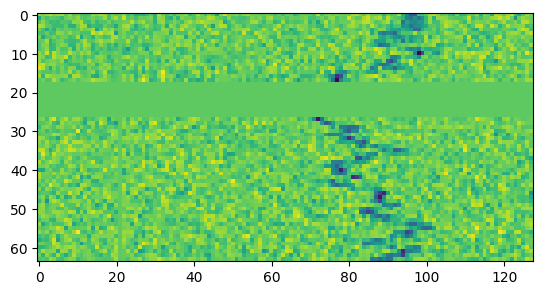

In [15]:
idx = 2 # Squiggle
image, label = trainset[idx]
plt.imshow(image.permute(0, 1, 2).squeeze())
print(label)

1


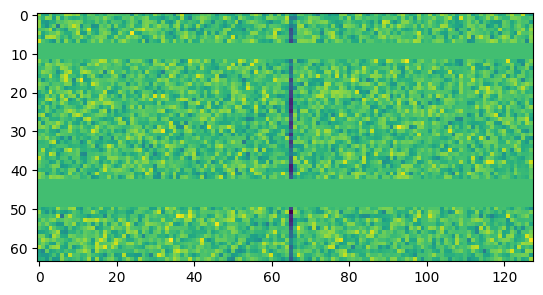

In [16]:
idx = 1102 # Narrowband_1
image, label = trainset[idx]
plt.imshow(image.permute(0, 1, 2).squeeze())
print(label)

2


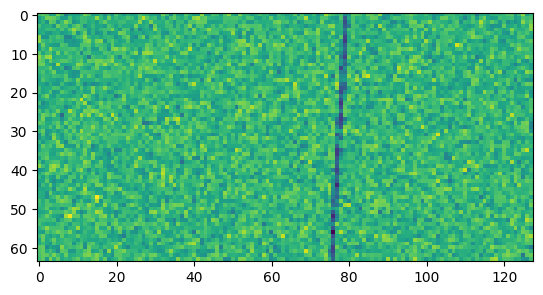

In [17]:
idx = 401 # Narrowband_2
image, label = trainset[idx]
plt.imshow(image.permute(0, 1, 2).squeeze())
print(label)

3


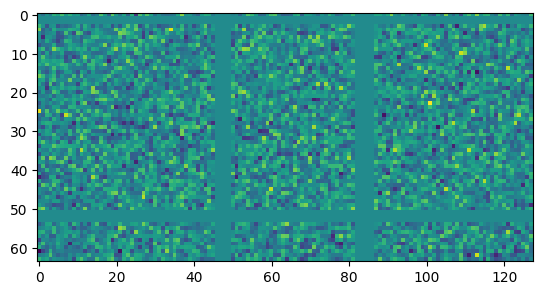

In [18]:
idx = 808 # Noise
image, label = trainset[idx]
plt.imshow(image.permute(0, 1, 2).squeeze())
print(label)

In [19]:
# Cross-check the sizes are equal to the labeled examples in training dataset
# and validation dataset respectively
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 1199
Size of Validset : 800


# 5) Load Dataset into Batches

In [20]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True) # Shuffle the batches
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [21]:
print(f"Number of batches in trainloader : {len(trainloader)}")
print(f"Number of batches in validloader : {len(validloader)}")

Number of batches in trainloader : 10
Number of batches in validloader : 7


In [22]:
for images, labels in trainloader:
    break;

print(f"One image batch shape : {images.shape}") # batch-size x channel x height x width
print(f"One label batch shape : {labels.shape}") # batch-size

One image batch shape : torch.Size([128, 1, 64, 128])
One label batch shape : torch.Size([128])


# 6) Create Radio Signal Classification Model

In [23]:
class RadioSignalClassificationModel(nn.Module):
    def __init__(self):
        super(RadioSignalClassificationModel, self).__init__()
        # 'num_classes' is the number of spectrogram image labels observed in
        # the input dataset which is equal to 4.
        # timm.create_model() output is a raw output in the form of logits.
        # The logits output from timm requires activation function like sigmoid or soft-max to be applied.
        self.net = timm.create_model(MODEL_NAME, num_classes=4, pretrained=True, in_chans=1)

    def forward(self, images, labels=None):
        # 'labels' will be set to None for inference or prediction from the trained model
        logits = self.net(images)
        if labels != None:
            # PyTorch cross entropy loss function requires logits and true labels as inputs.
            # PyTorch cross entropy loss function also applies soft-max activation function over the logits input.
            loss = nn.CrossEntropyLoss()
            return logits, loss(logits, labels)
        return logits

In [24]:
model = RadioSignalClassificationModel()
model.to(DEVICE) # Move to and run the model on GPU using CUDA and display the NN architecture

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

RadioSignalClassificationModel(
  (net): EfficientNet(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
        

# 7) Create Training and Validation Functions

In [25]:
def multiclass_accuracy(y_pred, y_true):
    top_p, top_class = y_pred.topk(1, dim=1)
    equals = (top_class == y_true.view(*top_class.shape))
    return torch.mean(equals.type(torch.FloatTensor))

In [26]:
def training(model, dataloader, optimizer, current_epoch):
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    progress_bar = tqdm(dataloader, desc="EPOCH" + " [TRAINING] " + str(current_epoch + 1) + "/" + str(EPOCHS))
    for t, data in enumerate(progress_bar):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad() # Set gradients to be zeros
        logits, loss = model(images, labels) # Run the model (i.e. classification model previously defined)
        loss.backward() # Compute gradients w.r.t the loss function; Do a backward pass
        optimizer.step() # Update the weights resulting in a gradient descent

        total_loss += loss.item()
        total_accuracy += multiclass_accuracy(logits, labels)

        temp = {'loss'     : '%6f' %float(total_loss/(t+1)),
                'accuracy' : '%6f' %float(total_accuracy/(t+1))} # 't' is an index for current running batch

        progress_bar.set_postfix(temp)

    # len(dataloader) will be equal to the number of batches executed by the model over training dataset
    return total_loss/len(dataloader), total_accuracy/len(dataloader)

In [27]:
def validation(model, dataloader, current_epoch):
    model.eval() # Avoids using any dropout layer(s)
    total_loss = 0.0
    total_accuracy = 0.0
    progress_bar = tqdm(dataloader, desc="EPOCH" + " [VALIDATION] " + str(current_epoch + 1) + "/" + str(EPOCHS))

    with torch.no_grad(): # Disable gradient computation
        for t, data in enumerate(progress_bar):
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            logits, loss = model(images, labels)

            total_loss += loss.item()
            total_accuracy += multiclass_accuracy(logits, labels)

            temp = {'loss'     : '%6f' %float(total_loss/(t+1)),
                    'accuracy' : '%6f' %float(total_accuracy/(t+1))} # 't' is an index for current running batch

            progress_bar.set_postfix(temp)

        return total_loss/len(dataloader), total_accuracy/len(dataloader)

# 8) Train the Model

In [28]:
def fit(model, trainloader, validloader, optimizer):
    # The best model is the one which has the best validation loss
    best_valid_loss = np.inf # Set to infinity initially

    for epoch_idx in range(EPOCHS):
        train_loss, train_accuracy = training(model, trainloader, optimizer, epoch_idx)
        valid_loss, valid_accuracy = validation(model, validloader, epoch_idx)
        # Save the best model
        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), MODEL_NAME + '-best-weights.pt')
            print('=== Best Model Saved! ===')
            best_valid_loss = valid_loss

In [29]:
# Pass weights, biases and learning rate to Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Train or fit the radio signal classification model over both training and validation datasets
fit(model, trainloader, validloader, optimizer)

EPOCH [TRAINING] 1/15:   0%|          | 0/10 [00:00<?, ?it/s]

EPOCH [VALIDATION] 1/15:   0%|          | 0/7 [00:00<?, ?it/s]

=== Best Model Saved! ===


EPOCH [TRAINING] 2/15:   0%|          | 0/10 [00:00<?, ?it/s]

EPOCH [VALIDATION] 2/15:   0%|          | 0/7 [00:00<?, ?it/s]

=== Best Model Saved! ===


EPOCH [TRAINING] 3/15:   0%|          | 0/10 [00:00<?, ?it/s]

EPOCH [VALIDATION] 3/15:   0%|          | 0/7 [00:00<?, ?it/s]

=== Best Model Saved! ===


EPOCH [TRAINING] 4/15:   0%|          | 0/10 [00:00<?, ?it/s]

EPOCH [VALIDATION] 4/15:   0%|          | 0/7 [00:00<?, ?it/s]

=== Best Model Saved! ===


EPOCH [TRAINING] 5/15:   0%|          | 0/10 [00:00<?, ?it/s]

EPOCH [VALIDATION] 5/15:   0%|          | 0/7 [00:00<?, ?it/s]

=== Best Model Saved! ===


EPOCH [TRAINING] 6/15:   0%|          | 0/10 [00:00<?, ?it/s]

EPOCH [VALIDATION] 6/15:   0%|          | 0/7 [00:00<?, ?it/s]

=== Best Model Saved! ===


EPOCH [TRAINING] 7/15:   0%|          | 0/10 [00:00<?, ?it/s]

EPOCH [VALIDATION] 7/15:   0%|          | 0/7 [00:00<?, ?it/s]

=== Best Model Saved! ===


EPOCH [TRAINING] 8/15:   0%|          | 0/10 [00:00<?, ?it/s]

EPOCH [VALIDATION] 8/15:   0%|          | 0/7 [00:00<?, ?it/s]

=== Best Model Saved! ===


EPOCH [TRAINING] 9/15:   0%|          | 0/10 [00:00<?, ?it/s]

EPOCH [VALIDATION] 9/15:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH [TRAINING] 10/15:   0%|          | 0/10 [00:00<?, ?it/s]

EPOCH [VALIDATION] 10/15:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH [TRAINING] 11/15:   0%|          | 0/10 [00:00<?, ?it/s]

EPOCH [VALIDATION] 11/15:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH [TRAINING] 12/15:   0%|          | 0/10 [00:00<?, ?it/s]

EPOCH [VALIDATION] 12/15:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH [TRAINING] 13/15:   0%|          | 0/10 [00:00<?, ?it/s]

EPOCH [VALIDATION] 13/15:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH [TRAINING] 14/15:   0%|          | 0/10 [00:00<?, ?it/s]

EPOCH [VALIDATION] 14/15:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH [TRAINING] 15/15:   0%|          | 0/10 [00:00<?, ?it/s]

EPOCH [VALIDATION] 15/15:   0%|          | 0/7 [00:00<?, ?it/s]

# 9) Inference

In [30]:
def view_classification(img, probs, true_label=None):
    classes = ["Squiggle", "Narrowband_1",  "Narrowband_2", "Noise"]

    # Copy tensor from GPU to CPU memory, convert to a numpy array and
    # remove any dimension of size 1
    probs = probs.data.cpu().numpy().squeeze()

    # Convert tensor to a numpy array
    img = img.numpy()

    fig, (ax1, ax2) = plt.subplots(figsize=(12,8), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    if true_label != None:
        ax1.set_title(f'Ground-Truth : {true_label}')
    ax2.barh(classes, probs) # Plot horizontal bar graph
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Radio Signal Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

def inference(idx):
    # Confirm the loss and accuracy numbers for the best model saved corresponding
    # to the log print "Best Model Saved!" over validation dataset in step (8)
    model.load_state_dict(torch.load('/content/efficientnet_b0-best-weights.pt'))

    image, label = validset[idx] # Returns a tensor image and its corresponding label
    image1 = image.permute(0, 1, 2).squeeze()

    # Normalize the tensor in the range [0, 1]
    logits = model(image.to(DEVICE).unsqueeze(0))
    logits -= logits.data.min()
    logits /= logits.data.max()
    view_classification(image1, logits, label)

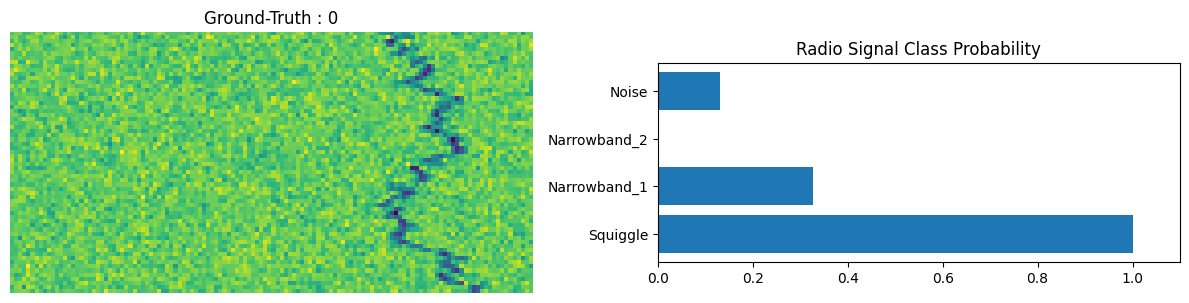

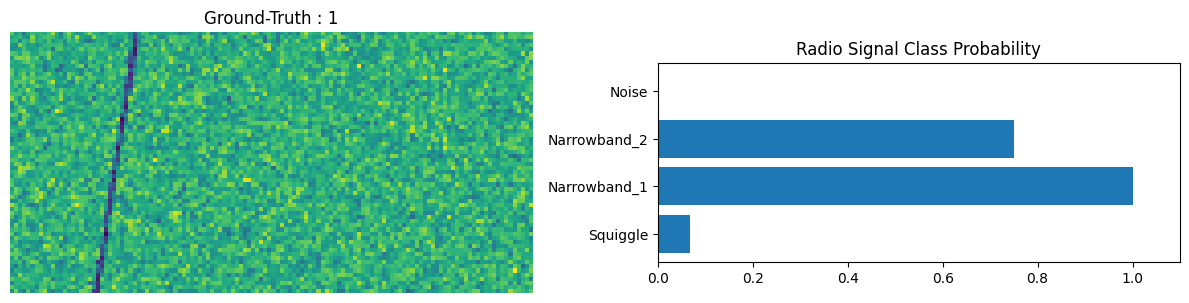

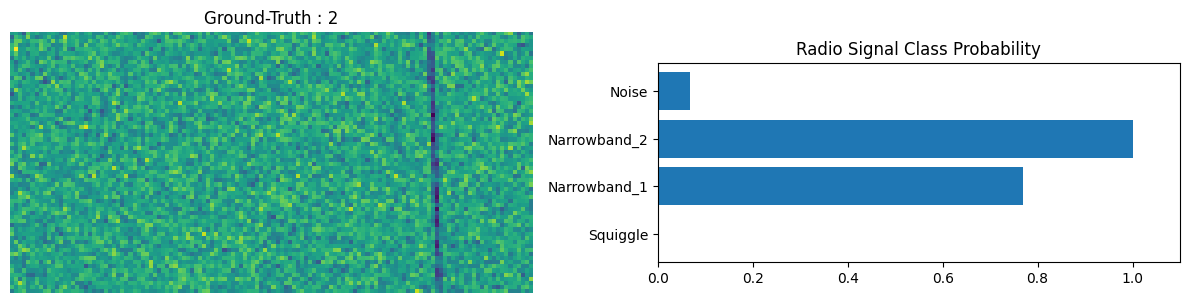

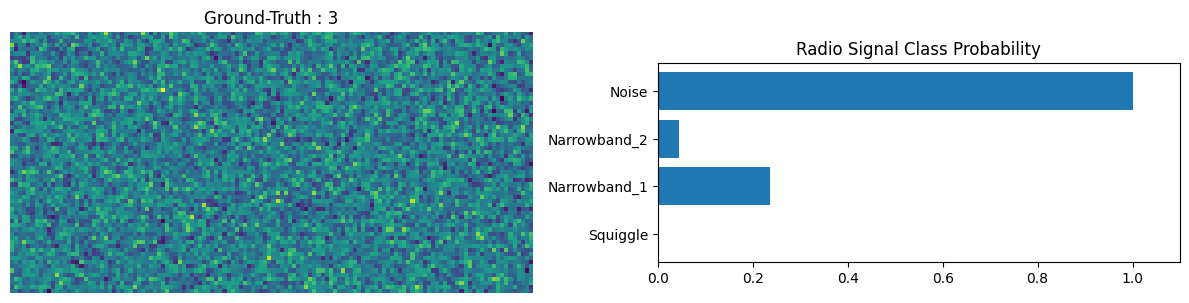

In [35]:
idx = 2 # Squiggle
inference(idx)

idx = 785 # Narrowband_1
inference(idx)

idx = 353 # Narrowband_2
inference(idx)

idx = 505 # Noise
inference(idx)